In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
CSV_TRAIN = f"{DRIVE_DIR}/train_split_dedup.csv"
CSV_VAL   = f"{DRIVE_DIR}/val_split_dedup.csv"
MODEL_OUT = f"{DRIVE_DIR}/cnn_skin_multilabel.keras"

print("✅ Paths ready.")


Mounted at /content/drive
✅ Paths ready.


In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

CLASSES = ["acne", "pigmentation", "wrinkles"]

train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col=CLASSES,
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col=CLASSES,
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 3562 validated image filenames.
Found 955 validated image filenames.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(CLASSES), activation='sigmoid')  # multi-label output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,339 (84.86 MB)

 Trainable params: 22,245,891 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

ckpt = ModelCheckpoint(
    MODEL_OUT,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lrred = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,       # You can increase later
    callbacks=[ckpt, early, lrred],
    verbose=1
)


Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6425 - loss: 1.7187 
Epoch 1: val_loss improved from inf to 2.34202, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/cnn_skin_multilabel.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 2912s 26s/step - accuracy: 0.6426 - loss: 1.7136 - val_accuracy: 0.6272 - val_loss: 2.3420 - learning_rate: 0.0010
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6977 - loss: 0.4897
Epoch 2: val_loss improved from 2.34202 to 0.69177, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/cnn_skin_multilabel.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 68s 606ms/step - accuracy: 0.6976 - loss: 0.4896 - val_accuracy: 0.7047 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6508 - loss: 0.2960
Epoch 3: val_loss did not improve from 0.69177
112/112 ━━━━━━━━━━━━━━━━━━━━ 72s 642ms/step - accuracy: 0.6508 - loss: 0.2959 - val_accuracy: 0.5927 - val

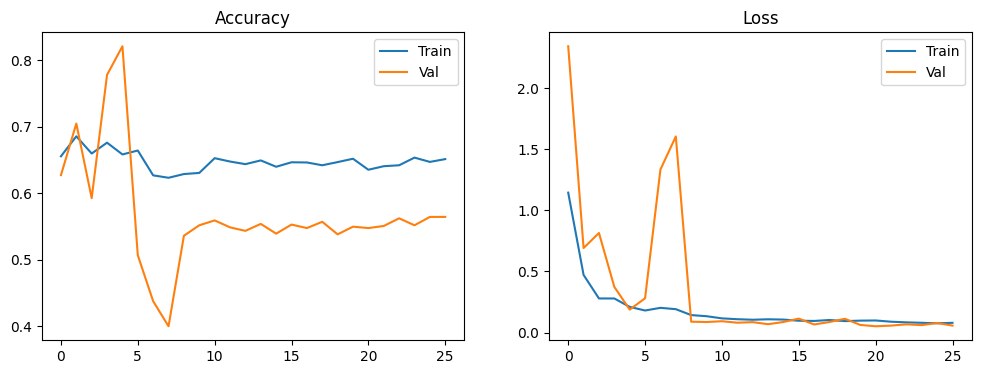

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step
ROC-AUC (macro): 0.9970

Classification Report (thr=0.5)
              precision    recall  f1-score   support

        acne       0.98      0.96      0.97       259
pigmentation       0.99      0.85      0.91        94
    wrinkles       0.94      0.93      0.93       191

   micro avg       0.97      0.93      0.95       544
   macro avg       0.97      0.91      0.94       544
weighted avg       0.97      0.93      0.95       544
 samples avg       0.53      0.53      0.53       544


===== AVERAGE (MACRO) METRICS =====
Accuracy : 0.9518
Precision: 0.9681
Recall   : 0.9118
AUC      : 0.9970


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Val")
plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title("Loss"); plt.legend()
plt.show()

val_gen.reset()
preds = model.predict(val_gen)
y_true = val_df[CLASSES].values

roc_auc = roc_auc_score(y_true, preds, average="macro")
print(f"ROC-AUC (macro): {roc_auc:.4f}")
print("\nClassification Report (thr=0.5)")
print(classification_report(y_true, (preds>0.5).astype(int), target_names=CLASSES))

# Average metrics
y_pred_bin = (preds > 0.5).astype(int)
macro_precision = precision_score(y_true, y_pred_bin, average='macro')
macro_recall    = recall_score(y_true, y_pred_bin, average='macro')
macro_acc       = accuracy_score(y_true, y_pred_bin)
macro_auc       = roc_auc_score(y_true, preds, average='macro')

print("\n===== AVERAGE (MACRO) METRICS =====")
print(f"Accuracy : {macro_acc:.4f}")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall   : {macro_recall:.4f}")
print(f"AUC      : {macro_auc:.4f}")


In [10]:
model.save(f"{DRIVE_DIR}/cnn_skin_multilabel_v1.keras")
print("✅ CNN model saved successfully.")


✅ CNN model saved successfully.
